# Low dimensional vowel measurement

In [1]:
import pandas as pd
import numpy as np
from matplotlib import cm
import matplotlib.pyplot as plt
from tensorflow.keras import models
from tensorflow.keras.utils import to_categorical
from imblearn.over_sampling import RandomOverSampler 
from sklearn.metrics import ConfusionMatrixDisplay
import librosa
from scipy.stats import dirichlet
from scipy.optimize import minimize

In [2]:
#Load the pretrained model 
model = models.load_model('CNN_no_devoiced_schwa_or_r_colored')

## Load the standard positions and test spectrogram data

In [3]:
#Get the chart standard positions and labels
sigma = 0.488
df_yv = pd.read_csv(f'yv_sigma_{sigma}.csv')
df_yv.head()

,phoneme,label,backness,height
0,iy,0,2.661934,-0.188168
1,ih,1,2.077788,1.008913
2,eh,2,1.851553,2.042779
3,ae,3,1.846348,3.223538
4,aa,4,-0.319155,2.823182


In [4]:
#Put the standard "backness" (z2) and "height" (z1) positions in a numpy array 
zv = np.array([df_yv.height.values,df_yv.backness.values]).T

#Get list of phonemes that we can measure, and create a dictionary of integer labels
phones = df_yv.phoneme
labels = df_yv.label
nv = len(phones)
cmap = cm.get_cmap('tab20')
colors = cmap(np.linspace(0,1,nv))
plabels = {}
for i,v in zip(labels,phones):
    plabels[v]=i
#Set up a dictionary to translate ARPAbet representations into IPA symbols
IPA_dict = {'iy':'\u0069','ih':'\u026a', 'eh':'\u025b', 'ae':'\u00e6', 'aa':'\u0251', 'ah':'\u028c',
            'ao':'\u0254', 'uh':'\u028a', 'uw':'\u0075', 'ux':'\u0289', 'er':'\u025d', 'ax':'\u0259',
            'ix':'\u0268', 'axr':'\u025a', 'ax-h':'\u0325\u0259'}

phonesIPA = np.array([IPA_dict[v] for v in phones])
phonesIPA

array(['i', 'ɪ', 'ɛ', 'æ', 'ɑ', 'ʌ', 'ɔ', 'ʊ', 'u', 'ʉ', 'ə', 'ɨ'],
      dtype='<U1')

In [5]:
#Load the spectrogram data
X_test = np.load('X_test_small.npy')
ph_test = np.load('ph_test_small.npy')
np.unique(ph_test)

array(['aa', 'ae', 'ah', 'ao', 'ax', 'eh', 'ih', 'ix', 'iy', 'uh', 'uw',
       'ux'], dtype='<U2')

highest frequency = 4210.4 Hz


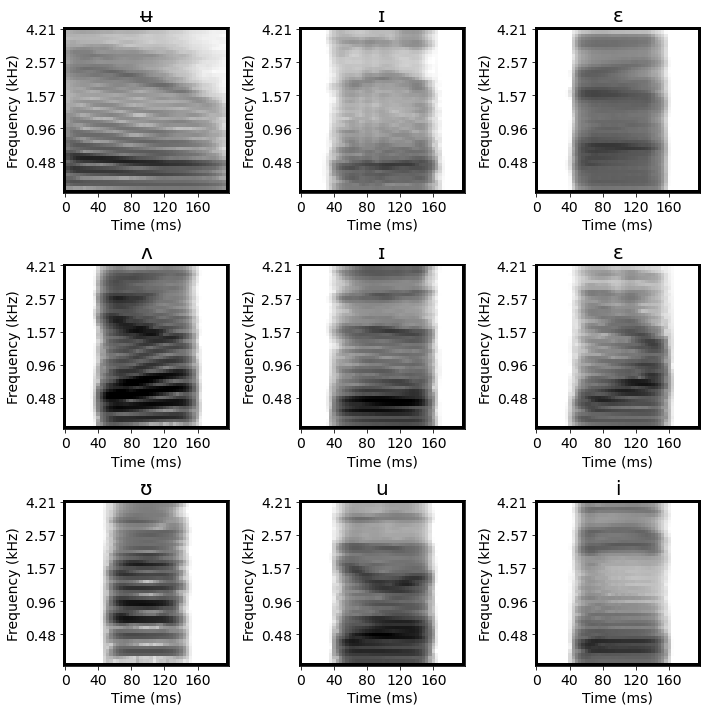

In [6]:
#Plot some spectrograms
#Get the mel band frequencies from librossa (parameters below have been set to match those used in paper)
#Sample rate
sr=16000
freqs = librosa.mel_frequencies(n_mels=64,fmin=0.0,fmax=sr/2.0)
print(f'highest frequency = {np.round(freqs[50],1)} Hz')
#Create x and y labels
y_pos=np.arange(0,50,10)
y_labs = np.round(freqs[50::-1][y_pos]/1000,2)
x_pos = np.arange(0,50,10)
times = np.arange(0,200,4)
x_labs = times[x_pos]

n=3

fig, ax = plt.subplots(n,n,figsize=(10,10))
L = X_test.shape[0]
for i in range(n):
    for j in range(n):
        k = np.random.randint(0,L)
        X = X_test[k].copy()[:,:,0]
        #Put a black border around each spectrogram (for presentation purposes)
        X[:,-1]=10
        X[:,0]=10
        X[-1,:]=10
        X[0,:]=10
        ax[i,j].imshow(X.T,cmap='Greys',vmin=-2,vmax=6)
        ax[i,j].set_title(IPA_dict[ph_test[k]],size=20)

        ax[i,j].set_yticks(y_pos,y_labs,size=14)
        ax[i,j].set_ylabel('Frequency (kHz)',size=14)

        ax[i,j].set_xticks(x_pos,x_labs,size=14)
        ax[i,j].set_xlabel('Time (ms)',size=14)

        k+=1
plt.tight_layout()
#plt.savefig(figure_folder/'spects_axes.pdf')
plt.show()

## Check performance of pretrained CNN model

Classification accuracy = 0.6966


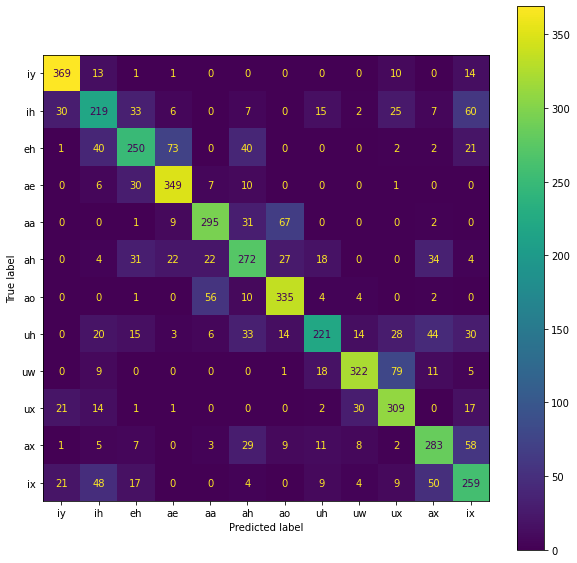

In [7]:
#Generate test predictions 
#Create vector of corresponding class labels (useful for plotting and checking accuracy of classifier)
y_test = np.array([plabels[v] for v in ph_test])
#CNN outputs probability mass function over phonemes for each spectrogram
CNN_probs = np.array(model.predict(X_test),dtype=float)
#Generate predictions (classes with maximum probability)
yp = np.argmax(CNN_probs,axis=1)
#Calculate accuracy
acc = (yp==y_test).mean()
print(f'Classification accuracy = {acc}')
fig,ax = plt.subplots(figsize=(10,10))
ConfusionMatrixDisplay.from_predictions(y_test, yp, display_labels=phones,ax=ax)
plt.show()

## Map CNN output probabilities to points in measurement space

In [8]:
#Vector of gaussian densities for each class at position z
#Recall that zv is vector of standard positions
def phi(z,zv,sigma):
    a = 0.5*((z-zv)**2).sum(axis=1)/sigma**2
    b = (2.0*np.pi)*sigma**2
    c= np.exp(-a)/b
    return c

#Probability mass function over classes, given z
def probs(z,zv,sigma):
    phis = phi(z,zv,sigma)
    return phis/phis.sum()

#Position in measurement space for which pmf best approximates CNN output
def zhat(CNN_ps,zv,sigma):
    norm = CNN_ps.sum()
    ps = CNN_ps/norm

    #Function we want to minimize (negative log dirichlet pdf)
    def f(z):
        A=1000.0
        qs = probs(z,zv,sigma)  
        #tmp = (A*qs-1)*np.log(ps) - sc.gammaln(A*qs)
        #return -tmp.sum()
        return -dirichlet.logpdf(ps,A*qs)
    
    #Place reasonable bounds on the result of the measurement
    a=2.5
    L0 = min(zv[:,0])-a
    R0 = max(zv[:,0])+a
    L1 = min(zv[:,1])-a
    R1 = max(zv[:,1])+a
    
    j = np.argmax(ps)
    z0 = zv[j]
    
    res = minimize(f,z0,bounds = [(L0,R0),(L1,R1)])
    return res.x  

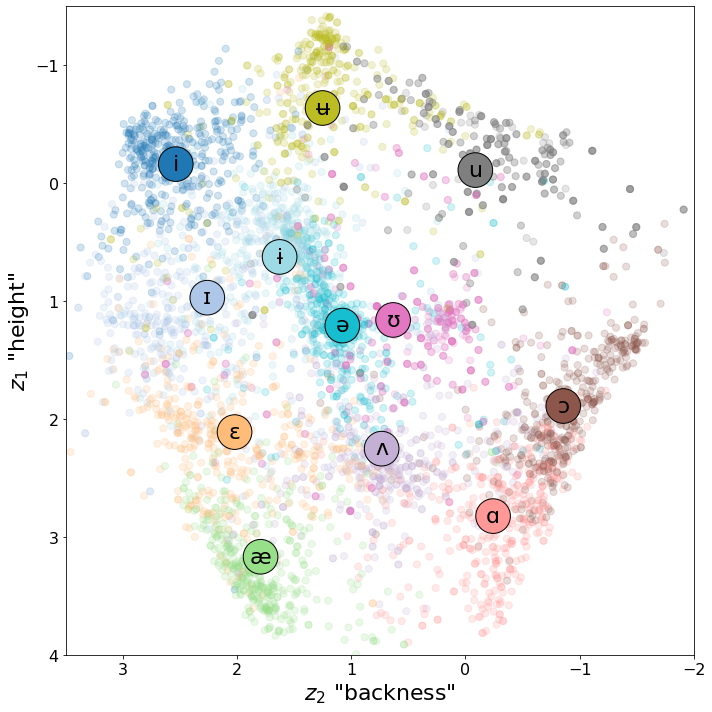

In [9]:
#Get measured positions
zhats = np.array([zhat(ps,zv,sigma) for ps in CNN_probs])
#Get category probs in the low dimensional model
phats = np.array([probs(z,zv,sigma) for z in zhats])

#Means and variances of measured categories (phonemes)
zhat_bars = np.array([zhats[y_test==i].mean(axis=0) for i in range(len(phones))])
zhat_vars = np.array([zhats[y_test==i].var(axis=0) for i in range(len(phones))])

#Create a scatter plot with phoneme labels at phoneme means
fig,ax = plt.subplots(figsize=(10,10))
ax.scatter(zhats[:,1],zhats[:,0],c=y_test,cmap='tab20',alpha=0.2,s=50,rasterized=True)

ax.scatter(zhat_bars[:,1],zhat_bars[:,0],s=1200,alpha=1,c=colors,edgecolors='black')
for i, txt in enumerate(phonesIPA):
    ax.annotate(txt, (zhat_bars[i,1], zhat_bars[i,0]),size=22,ha='center',va='center')  


ax.set_xlim(-2,3.5)
ax.set_ylim(-1.5,4)
ax.set_xlabel('$z_2$ "backness"',size=22)
ax.set_ylabel('$z_1$ "height"',size=22)
ax.tick_params(labelsize=16 )
ax.invert_xaxis()
ax.invert_yaxis()
plt.tight_layout()
#plt.savefig(figure_folder/'measurement_dirichlet.pdf',dpi=150)
plt.show()

## Some investigations of the relationship between CNN and model probability mass functions

Mean TVD between CNN output and 2D model = 0.11880773824898842


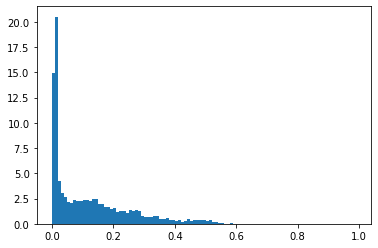

In [10]:
#Calculate total variation distances between CNN output probabilities and low dimensional model probabilities
#Note that the mean TVD is close to 0.1, which is consistent with the TVD of 0.1 between the similarity matrix of the CNN 
#and the similarity matrix of the low dimensional model
TVDs = 0.5*np.abs(phats-CNN_probs).sum(axis=1)
print(f'Mean TVD between CNN output and 2D model = {TVDs.mean()}')
plt.hist(TVDs,bins=np.arange(0,1,0.01),density=True)
plt.show()

Average maximum prob = 0.738440350586176


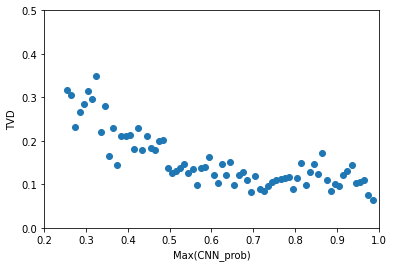

In [12]:
#Check if there is a relationship between the magnitude of the highest CNN probability 
#and the ability of the model to approximate the pmf.
#The size of the highest probability measures the "confidence" of the CNN in its prediction 
#Observation: the model is slightly less effective at approximating the CNN output probs when the 
#CNN is less confident about the category (that is, one category doesn't "stand out" at the most likely)  
pmaxs = np.max(CNN_probs,axis=1)
print(f'Average maximum prob = {pmaxs.mean()}')
bins = np.arange(0.25,1,0.01)
mids = 0.5*(bins[1:]+bins[:-1])
idxs=np.digitize(pmaxs,bins=bins)
TVDmeans = [TVDs[idxs==k].mean() for k in range(1,len(bins))]
plt.scatter(mids,TVDmeans)
plt.xlim(0.2,1)
plt.ylim(0,0.5)
plt.xlabel('Max(CNN_prob)')
plt.ylabel('TVD')
plt.show()